In [ ]:
!pip install highway-env

import gymnasium as gym
import highway_env

import scipy.linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange

from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.2 MB/s eta 0:00:00


In [ ]:
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [ ]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=2000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            if done:
              previous_obs, info = env.reset()
            obs, reward, done, truncated, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
            previous_obs = obs
    return data

env = gym.make("parking-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000,  0.0000, -0.8646,  0.5025]), action=tensor([ 0.3503, -0.7907]), next_state=tensor([-1.5044e-04,  1.7859e-04, -6.0456e-02,  3.5391e-02, -8.6300e-01,
         5.0520e-01]))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems*

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation comes from the Control Theory community and stands for the state and action $(s,a)$. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [ ]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:", dynamics(data[0].state.unsqueeze(0),
                                                                data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.0466, -0.0092, -0.0587,  0.0059, -0.8294,  0.4795]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

Train dynamics:   0%|          | 0/1500 [00:00<?, ?it/s]

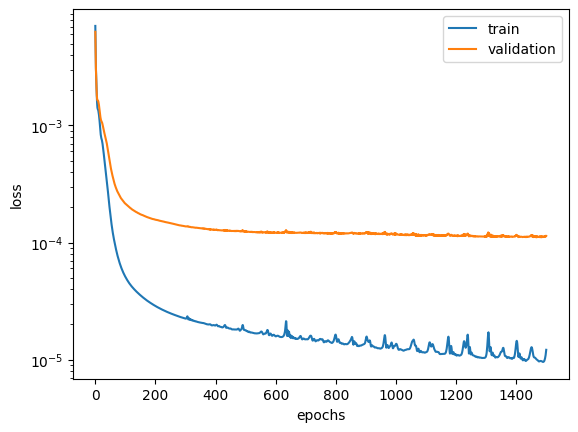

In [ ]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "validation"])
    plt.show()

train(dynamics, train_data, validation_data)

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


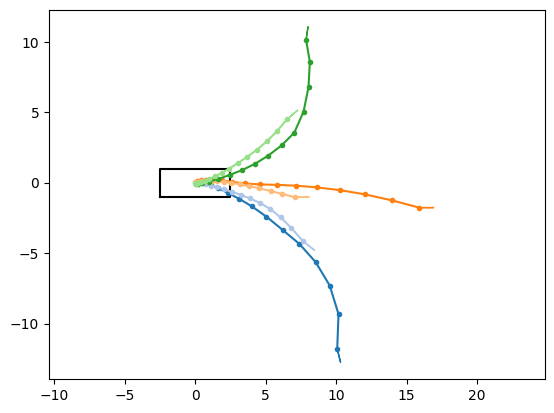

In [ ]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()

visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [ ]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.4923])


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [ ]:
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = torch.normal(mean=action_mean.repeat(1, population, 1), std=action_std.repeat(1, population, 1))
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean = best_actions.mean(dim=1, keepdim=True)
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)


# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
print("Planned action:", action)

Planned action: tensor([-0.9827, -0.6490])


In [ ]:
def mpc_planner(dynamics, state, goal, horizon=10, max_iters=10, alpha=0.1):
    n_state = state.shape[0]
    n_action = env.action_space.shape[0]

    actions = torch.zeros(horizon, n_action, requires_grad=True)

    optimizer = torch.optim.Adam([actions], lr=alpha)

    for i in range(max_iters):
        states = [state]
        for t in range(horizon):
            next_state = dynamics(states[-1].unsqueeze(0), actions[t].unsqueeze(0)).squeeze(0)
            states.append(next_state)

        states = torch.stack(states)
        cost = -reward_model(states, goal).sum()

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        with torch.no_grad():
            actions.clamp_(min=env.action_space.low.min(), max=env.action_space.high.max())

        if cost.item() < 1e-3:
            break

    return actions[0].detach()

# Run the planner on a sample transition
obs, info = env.reset()
action = mpc_planner(dynamics, torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]))
print("Planned action:", action)

Planned action: tensor([-0.9767, -0.3347])


In [ ]:
import torch
import torch.nn.functional as F

def old_ilqr_planner(state, goal, dynamics_model, action_size, state_size, horizon=15, iterations=20, learning_rate=0.05):
    action_sequence = torch.zeros(horizon, action_size, requires_grad=True)
    def compute_cost(states, goal):
        reward_weights = torch.Tensor(env.unwrapped.config["reward_weights"])
        cost = torch.norm((states - goal) * reward_weights, p=1, dim=-1)
        return cost
    optimizer = torch.optim.Adam([action_sequence], lr=learning_rate)
    for _ in range(iterations):
        optimizer.zero_grad()
        current_state = state.unsqueeze(0)
        states = [current_state]
        for t in range(horizon):
            action = action_sequence[t].unsqueeze(0)
            next_state = dynamics_model(current_state, action)
            states.append(next_state)
            current_state = next_state
        states = torch.cat(states, dim=0)
        total_cost = compute_cost(states.squeeze(1), goal).sum()
        total_cost.backward()
        optimizer.step()
        with torch.no_grad():
            action_sequence.data = torch.clamp(action_sequence, min=env.action_space.low.min(), max=env.action_space.high.max())
    return action_sequence[0].detach()

# Run the planner on a sample transition
action = ilqr_planner(torch.Tensor(obs["observation"]),
                      torch.Tensor(obs["desired_goal"]),
                      dynamics,
                      env.action_space.shape[0],
                      env.observation_space.spaces["observation"].shape[0])
print("Planned action:", action)


Planned action: tensor([0.8126, 0.2342])


In [ ]:
import torch
import torch.nn.functional as F

def ilqr_planner(state, goal, dynamics_model, action_size, state_size, horizon=20, iterations=15, learning_rate=0.02):
    action_sequence = torch.zeros(horizon, action_size, requires_grad=True)
    def compute_cost(states, goal):
        reward_weights = torch.Tensor(env.unwrapped.config["reward_weights"])
        cost = torch.norm((states - goal) * reward_weights, p=1, dim=-1)
        return cost
    optimizer = torch.optim.Adam([action_sequence], lr=learning_rate)
    for _ in range(iterations):
        optimizer.zero_grad()
        current_state = state.unsqueeze(0)
        states = [current_state]
        for t in range(horizon):
            action = action_sequence[t].unsqueeze(0)
            next_state = dynamics_model(current_state, action)
            states.append(next_state)
            current_state = next_state
        states = torch.cat(states, dim=0)
        total_cost = compute_cost(states.squeeze(1), goal).sum()
        total_cost.backward()
        optimizer.step()
        with torch.no_grad():
            action_sequence.data = torch.clamp(action_sequence, min=env.action_space.low.min(), max=env.action_space.high.max())
    return action_sequence[0].detach()

# Run the planner on a sample transition
action = ilqr_planner(torch.Tensor(obs["observation"]),
                      torch.Tensor(obs["desired_goal"]),
                      dynamics,
                      env.action_space.shape[0],
                      env.observation_space.spaces["observation"].shape[0])
print("Planned action:", action)


Planned action: tensor([-0.2929, -0.0607])


ТЕСТИРОВАНИЕ

In [ ]:
import time
import matplotlib.pyplot as plt
from tqdm import trange

def test_planners(planners, env, num_tests=5, num_steps=100):
    results = []

    for planner_name, planner in planners.items():
        for test_num in range(num_tests):
            obs, info = env.reset()
            initial_state = torch.Tensor(obs["observation"])
            goal_state = torch.Tensor(obs["desired_goal"])

            start_time = time.time()
            total_reward = 0
            crashed = False
            stuck = False
            trajectory = [initial_state.numpy()]

            for step in range(num_steps):
                action = planner(initial_state, goal_state, env.action_space.shape[0], env.observation_space.spaces["observation"].shape[0])
                obs, reward, done, truncated, info = env.step(action.numpy())
                total_reward += reward
                trajectory.append(torch.Tensor(obs["observation"]).numpy())

                if done:
                    break
                if truncated:
                    stuck = True
                    break
                if info.get('crashed', False):
                    crashed = True
                    break

                initial_state = torch.Tensor(obs["observation"])

            end_time = time.time()
            elapsed_time = end_time - start_time

            results.append({
                "Planner": planner_name,
                "Test Number": test_num + 1,
                "Total Reward": total_reward,
                "Elapsed Time": elapsed_time,
                "Crashed": crashed,
                "Stuck": stuck
            })

            plot_trajectory(trajectory, env, goal_state.numpy(), planner_name, test_num + 1)

    return results

def plot_trajectory(trajectory, env, goal, planner_name, test_num):
    plt.figure(figsize=(10, 10))
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    trajectory = np.array(trajectory) * scales
    goal = goal * scales

    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', marker='.')
    plt.plot(goal[0] + 2.5 * np.array([-1, -1, 1, 1, -1]), goal[1] + 1.0 * np.array([-1, 1, 1, -1, -1]), 'r--')
    plt.plot(trajectory[0, 0] + 2.5 * np.array([-1, -1, 1, 1, -1]), trajectory[0, 1] + 1.0 * np.array([-1, 1, 1, -1, -1]), 'g-')
    plt.title(f"Trajectory for {planner_name}, Test {test_num}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

# Пример использования:
planners = {
    "CEM Planner": lambda state, goal, action_size, state_size: cem_planner(state, goal, action_size),
    "MPC Planner": lambda state, goal, action_size, state_size: mpc_planner(dynamics, state, goal),
    "ILQR Planner": lambda state, goal, action_size, state_size: ilqr_planner(state, goal, dynamics, action_size, state_size)
}

env = gym.make("parking-v0")
results = test_planners(planners, env)

# Вывод результатов в виде таблицы
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)



Новое тестирование

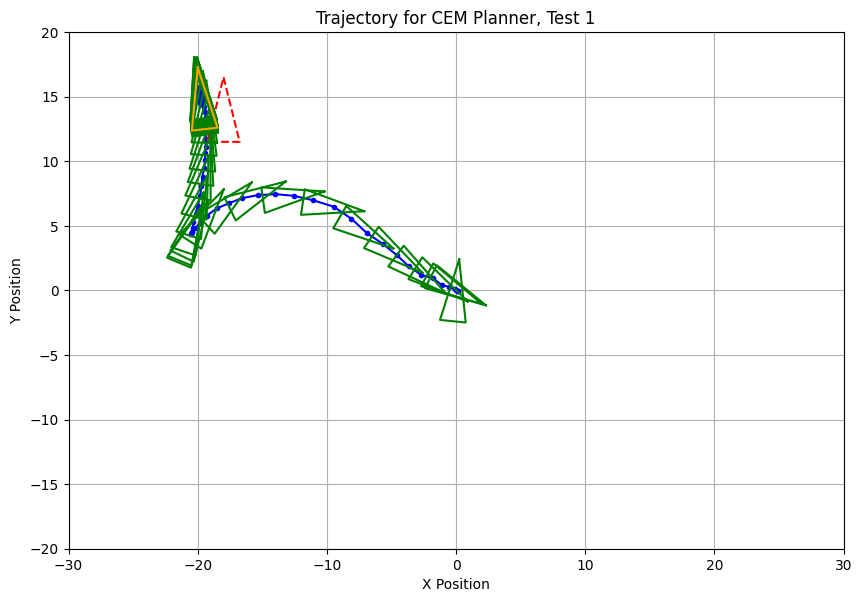

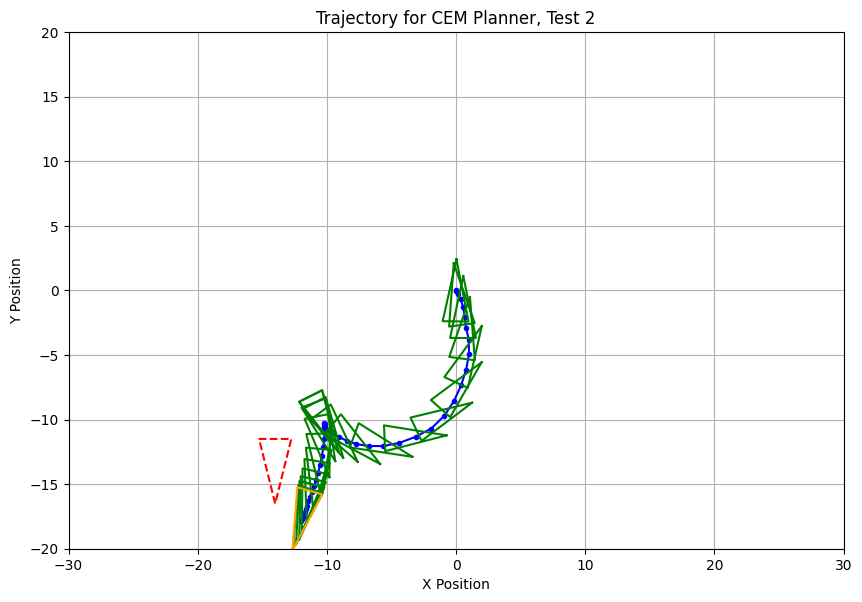

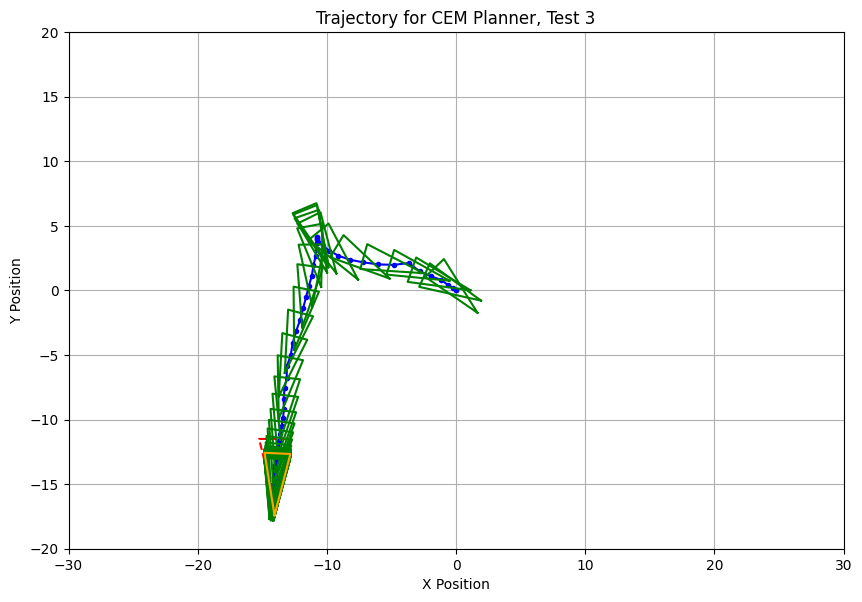

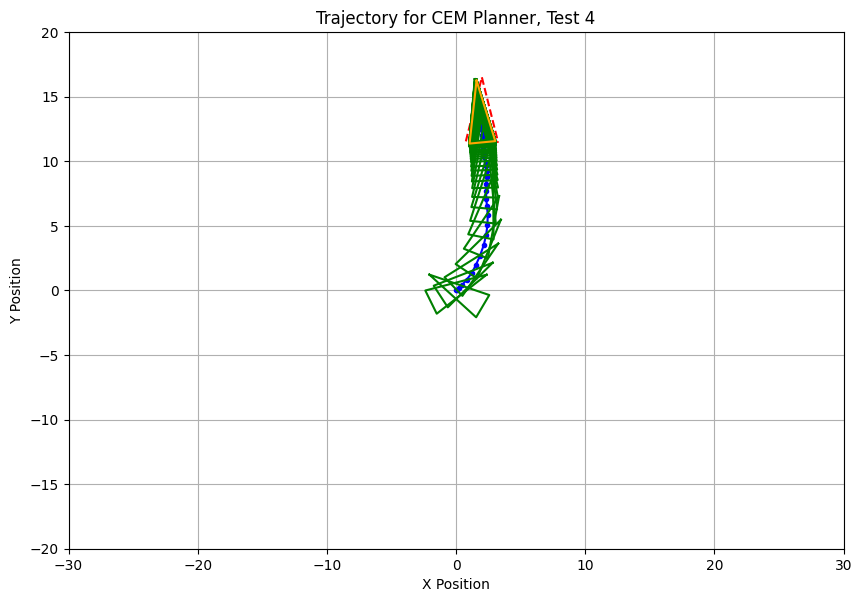

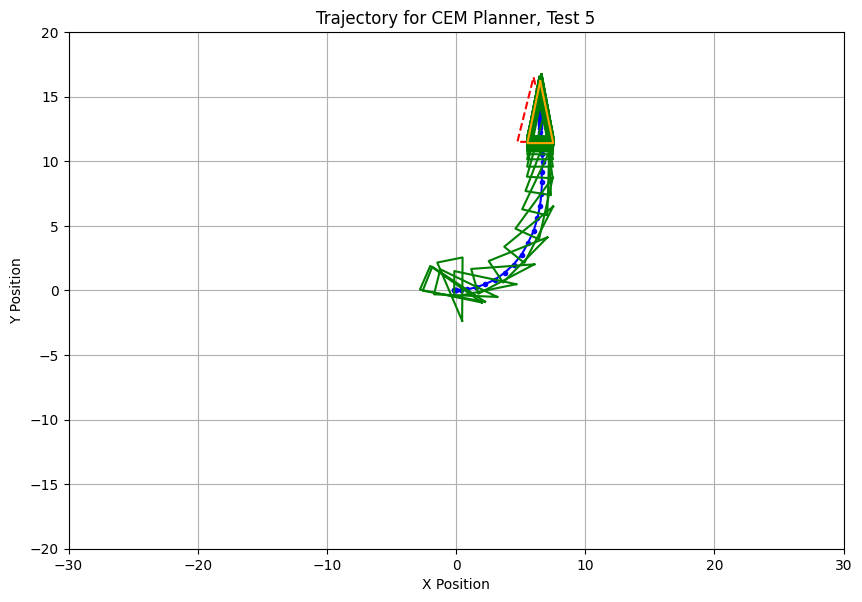

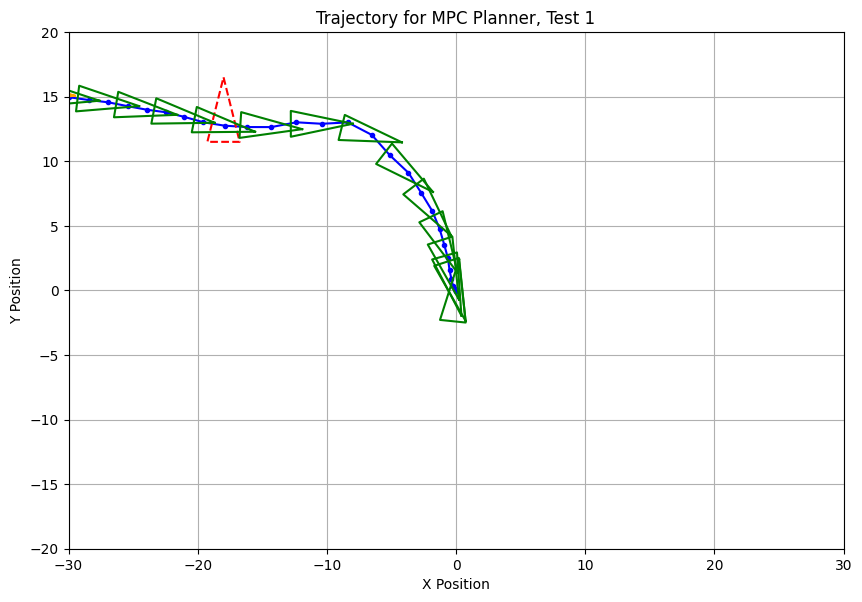

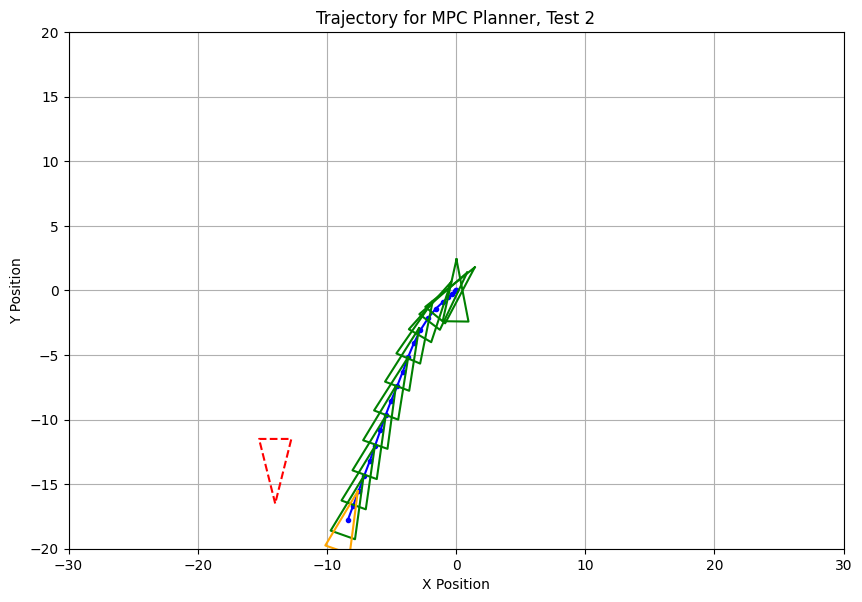

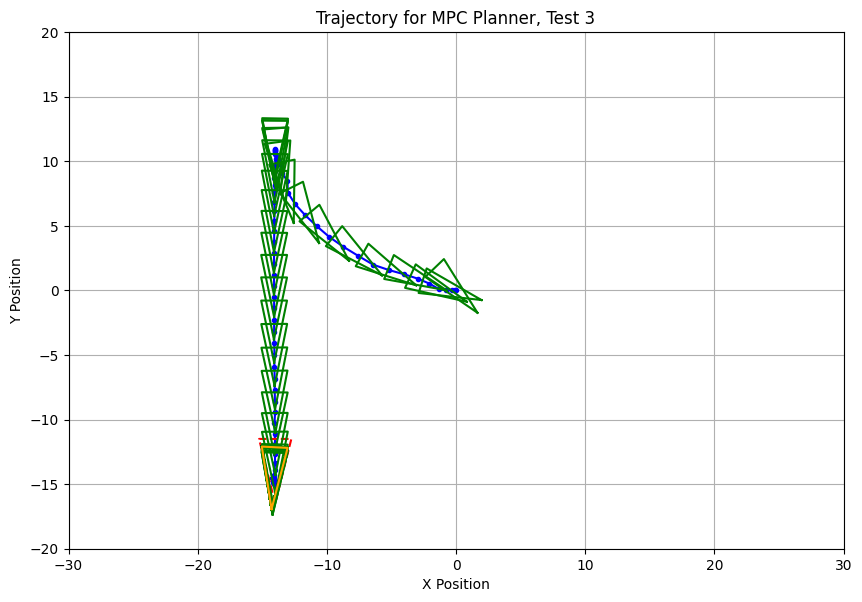

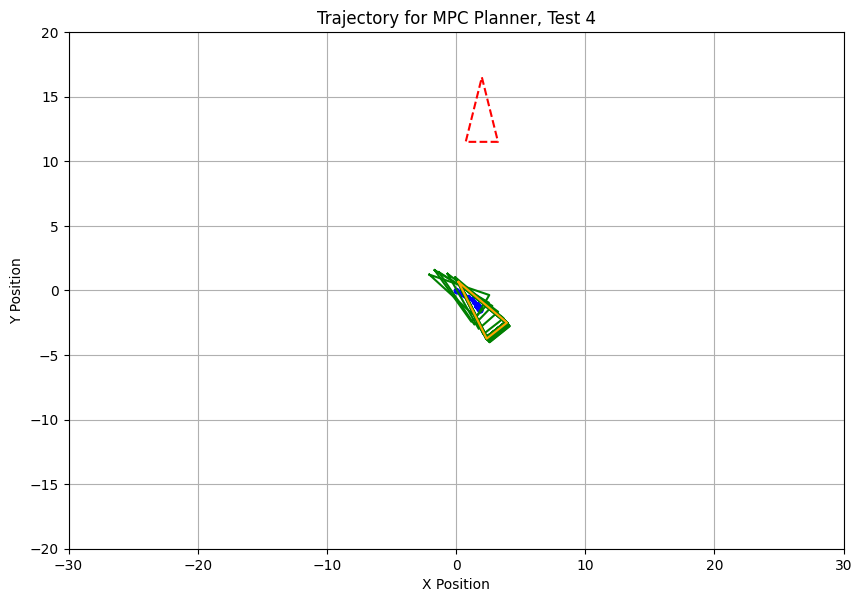

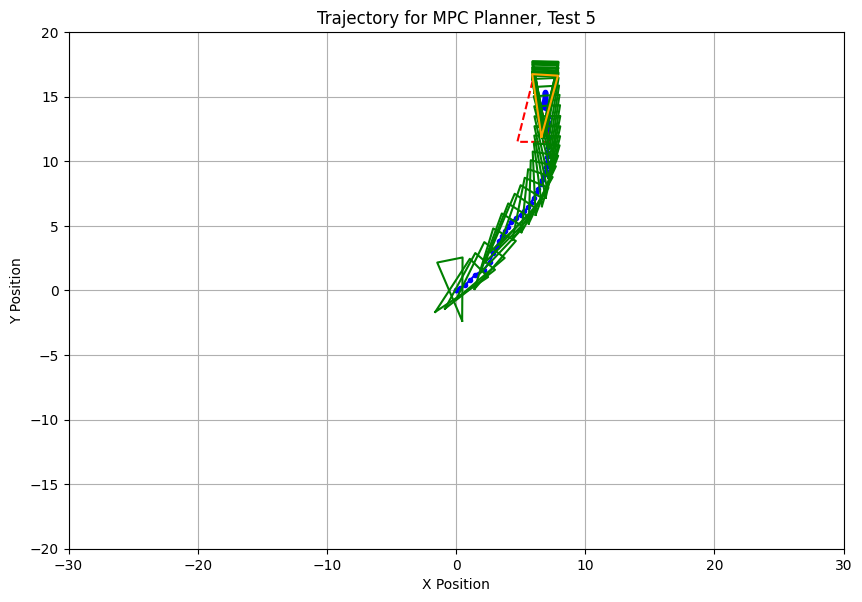

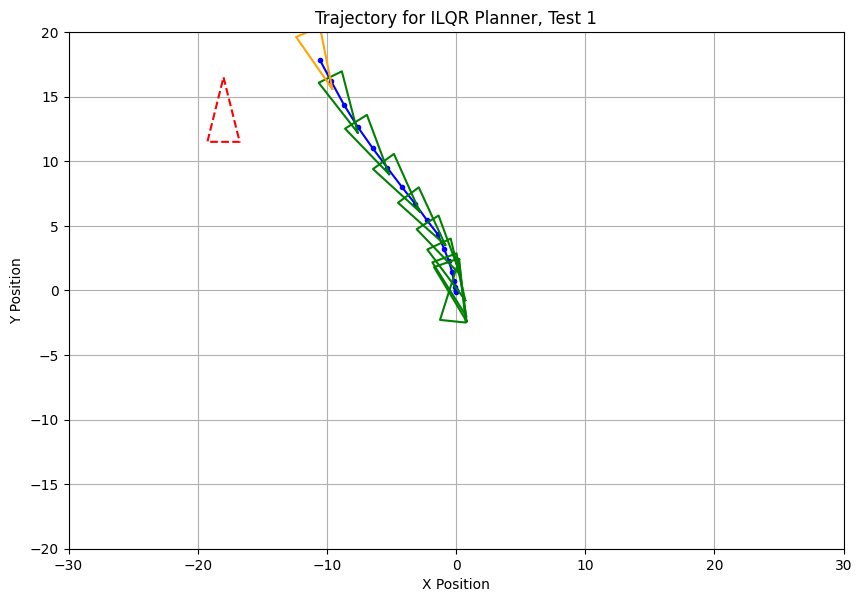

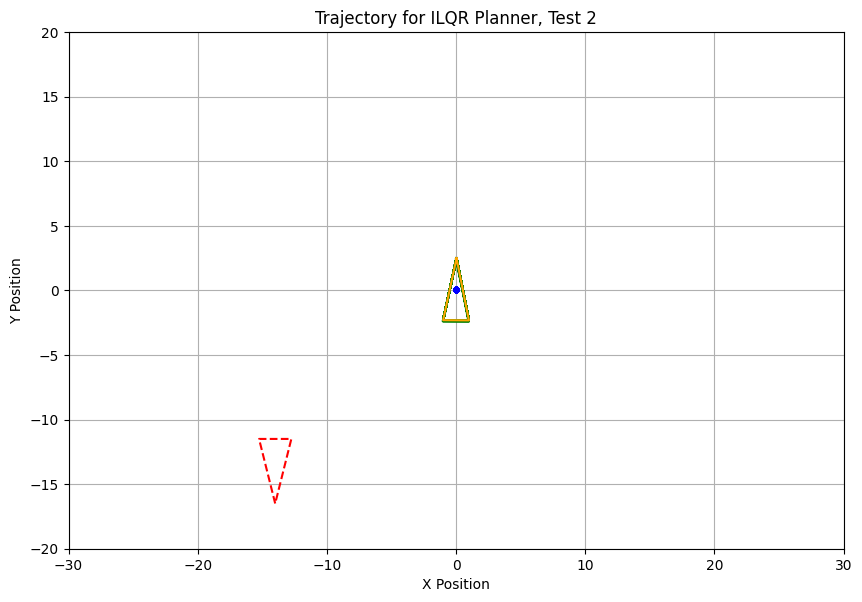

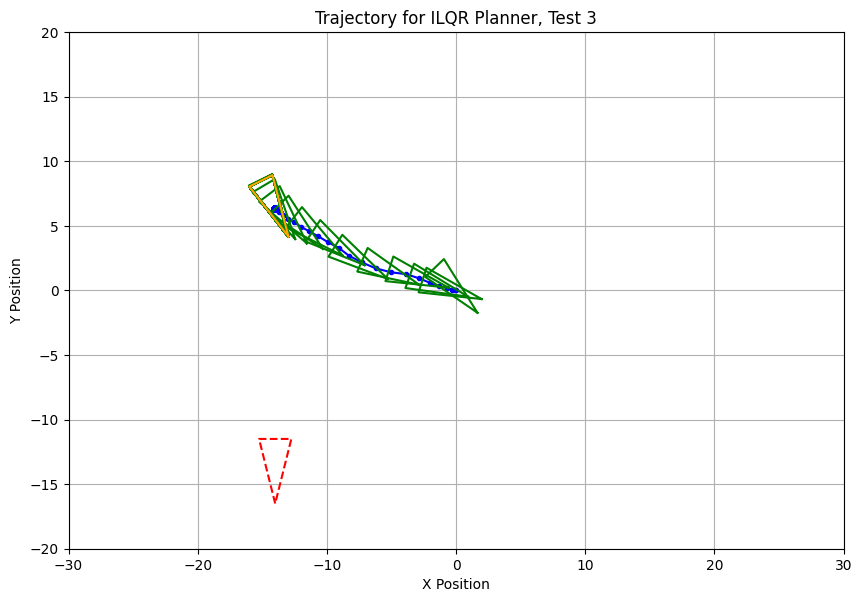

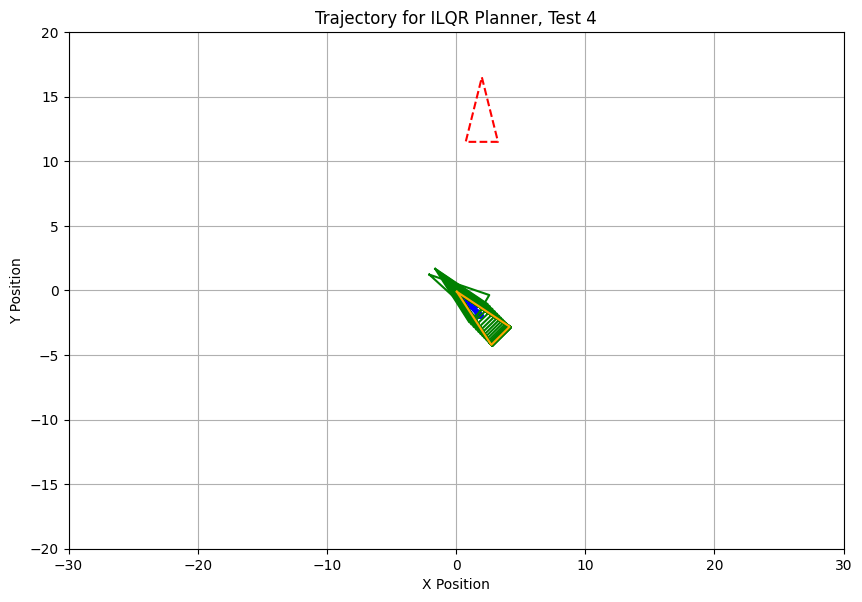

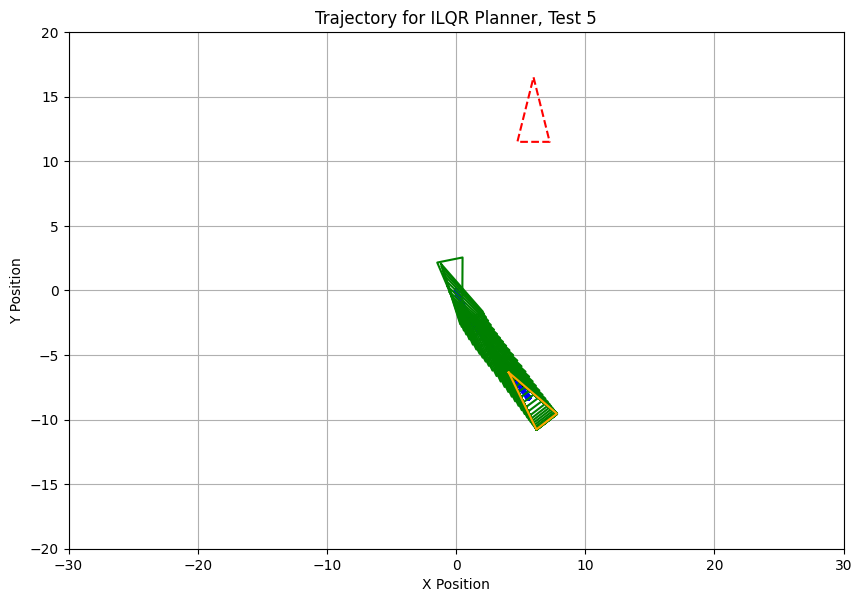

         Planner  Test Number  Total Reward  Elapsed Time  Crashed  Stuck  \
0    CEM Planner            1   -192.203643     35.025820    False   True   
1    CEM Planner            2    -30.588307      3.089924    False  False   
2    CEM Planner            3   -224.975842     34.887689    False   True   
3    CEM Planner            4   -285.417552     35.070003    False   True   
4    CEM Planner            5   -248.591168     33.268446    False   True   
5    MPC Planner            1    -16.869901      3.862194    False  False   
6    MPC Planner            2    -13.640872      2.037475    False  False   
7    MPC Planner            3   -346.143550     51.897719    False   True   
8    MPC Planner            4   -211.432832     51.943693    False   True   
9    MPC Planner            5   -287.299630     50.999135    False   True   
10  ILQR Planner            1    -11.701247      4.275203    False  False   
11  ILQR Planner            2   -213.369819    129.904373    False   True   

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

def set_env_state(env, observation, achieved_goal, desired_goal):
    env.reset()
    env.unwrapped.state = {
        'observation': observation.numpy(),
        'achieved_goal': achieved_goal.numpy(),
        'desired_goal': desired_goal.numpy()
    }

def plot_trajectory(trajectory, env, goal, planner_name, test_num, draw_interval=1):
    plt.figure(figsize=(10, 10))
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    trajectory = np.array(trajectory) * scales
    goal = goal * scales

    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', marker='.')

    # Drawing the parking spot as a triangle
    parking_spot_length = 5.0
    parking_spot_width = 2.5
    goal_x, goal_y = goal[0], goal[1]
    goal_sin, goal_cos = goal[5], goal[4]
    parking_spot_orientation = np.arctan2(goal_sin, goal_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
    triangle = np.array([
        [0, -parking_spot_length / 2],
        [-parking_spot_width / 2, parking_spot_length / 2],
        [parking_spot_width / 2, parking_spot_length / 2],
    ])
    rotation_matrix = np.array([
        [np.cos(parking_spot_orientation), -np.sin(parking_spot_orientation)],
        [np.sin(parking_spot_orientation), np.cos(parking_spot_orientation)]
    ])
    triangle = triangle @ rotation_matrix.T + np.array([goal_x, goal_y])
    plt.plot([triangle[0, 0], triangle[1, 0], triangle[2, 0], triangle[0, 0]],
             [triangle[0, 1], triangle[1, 1], triangle[2, 1], triangle[0, 1]], 'r--')

    for i, state in enumerate(trajectory):
        if i % draw_interval == 0 or i == len(trajectory) - 1:
            # Drawing the car as a triangle
            car_x, car_y = state[0], state[1]
            car_sin, car_cos = state[5], state[4]
            car_yaw = np.arctan2(car_sin, car_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
            car_length = 4.8
            car_width = 2.0
            car_triangle = np.array([
                [0, -car_length / 2],
                [-car_width / 2, car_length / 2],
                [car_width / 2, car_length / 2],
            ])
            rotation_matrix = np.array([
                [np.cos(car_yaw), -np.sin(car_yaw)],
                [np.sin(car_yaw), np.cos(car_yaw)]
            ])
            car_triangle = car_triangle @ rotation_matrix.T + np.array([car_x, car_y])
            color = 'g-' if i != len(trajectory) - 1 else 'orange'
            plt.plot([car_triangle[0, 0], car_triangle[1, 0], car_triangle[2, 0], car_triangle[0, 0]],
                     [car_triangle[0, 1], car_triangle[1, 1], car_triangle[2, 1], car_triangle[0, 1]], color)

    plt.title(f"Trajectory for {planner_name}, Test {test_num}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-30, 30)
    plt.ylim(-20, 20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

def test_planners(planners, env, num_tests=5, num_steps=100, draw_interval=1):
    results = []
    initial_conditions = []
    for test_num in range(num_tests):
        obs, info = env.reset()
        initial_state = torch.Tensor(obs["observation"])
        achieved_goal = torch.Tensor(obs["achieved_goal"])
        desired_goal = torch.Tensor(obs["desired_goal"])
        initial_conditions.append((initial_state, achieved_goal, desired_goal))
    env.unwrapped.config["duration"] = num_steps
    for planner_name, planner in planners.items():
        for test_num, (initial_state, achieved_goal, desired_goal) in enumerate(initial_conditions):
            set_env_state(env, initial_state, achieved_goal, desired_goal)
            start_time = time.time()
            total_reward = 0
            crashed = False
            stuck = False
            trajectory = [initial_state.numpy()]
            done = False
            while not done:
                action = planner(initial_state, desired_goal, env.action_space.shape[0], env.observation_space.spaces["observation"].shape[0])
                obs, reward, done, truncated, info = env.step(action.numpy())
                total_reward += reward
                trajectory.append(torch.Tensor(obs["observation"]).numpy())
                if done:
                    break
                if truncated:
                    stuck = True
                    break
                if info.get('crashed', False):
                    crashed = True
                    break
                initial_state = torch.Tensor(obs["observation"])
            end_time = time.time()
            elapsed_time = end_time - start_time
            success = not crashed and not stuck and done
            results.append({
                "Planner": planner_name,
                "Test Number": test_num + 1,
                "Total Reward": total_reward,
                "Elapsed Time": elapsed_time,
                "Crashed": crashed,
                "Stuck": stuck,
                "Success": success
            })
            plot_trajectory(trajectory, env, desired_goal.numpy(), planner_name, test_num + 1, draw_interval)
    return results


planners = {
    "CEM Planner": lambda state, goal, action_size, state_size: cem_planner(state, goal, action_size),
    "MPC Planner": lambda state, goal, action_size, state_size: mpc_planner(dynamics, state, goal),
    "ILQR Planner": lambda state, goal, action_size, state_size: ilqr_planner(state, goal, dynamics, action_size, state_size)
}

env = gym.make("parking-v0", render_mode='rgb_array')
results = test_planners(planners, env, draw_interval=2)

# Вывод результатов в виде таблицы
df_results = pd.DataFrame(results)
print(df_results)

# Сохранение результатов в Excel файл
df_results.to_excel("test_results.xlsx", index=False)

Моя модификация тестирования

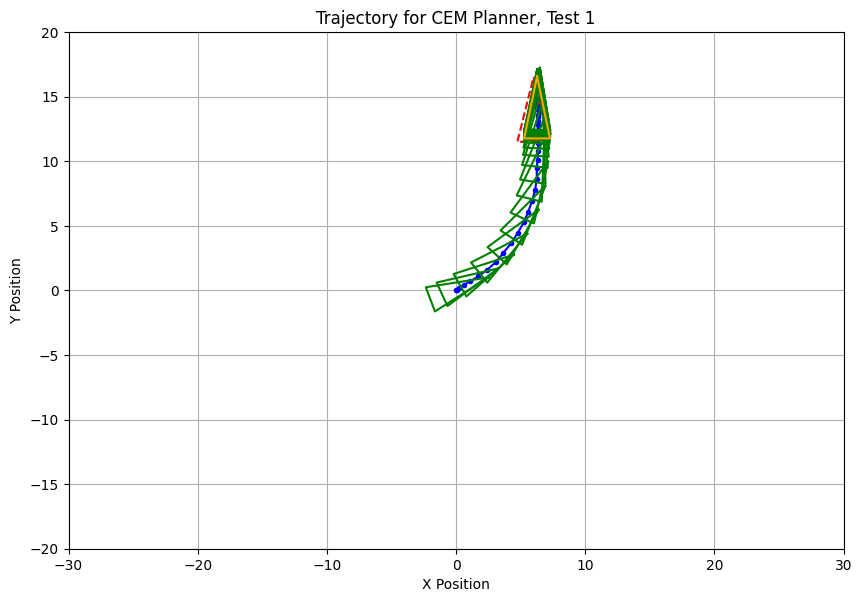

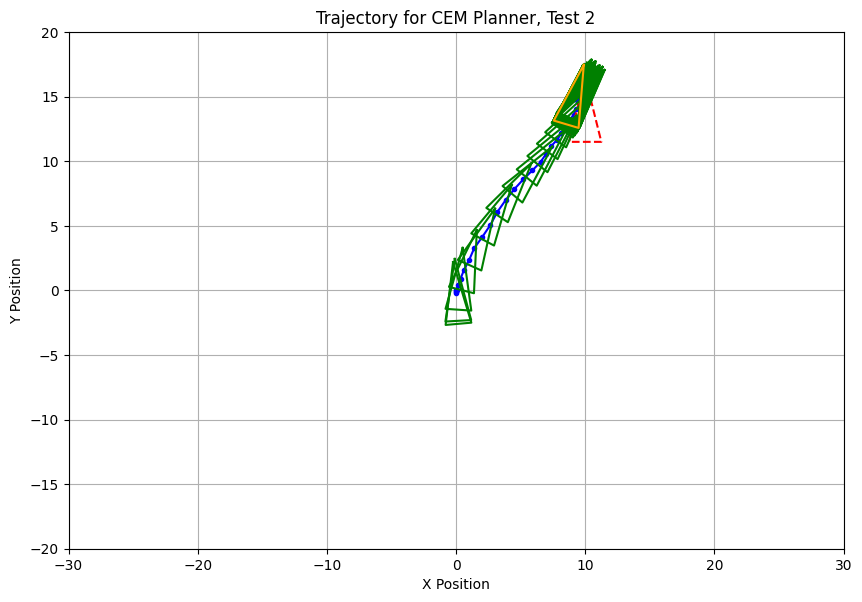

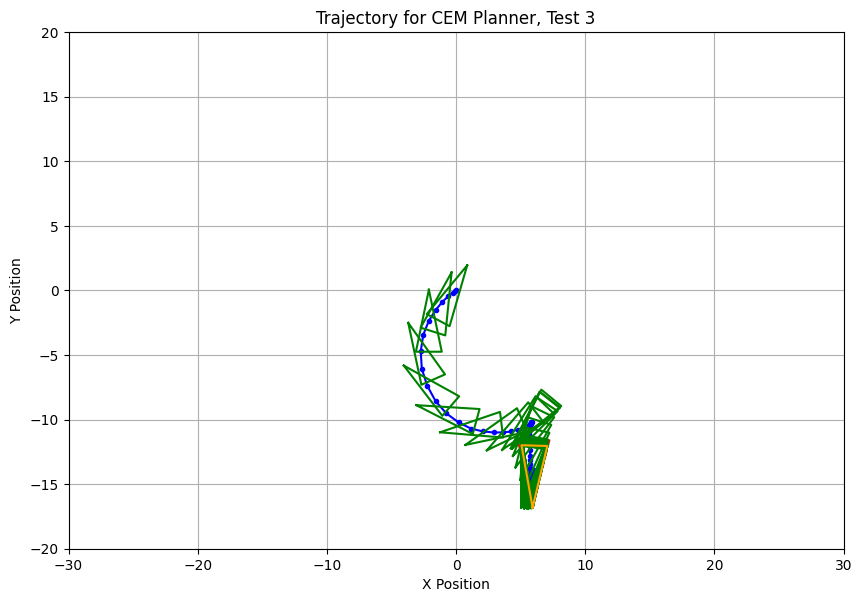

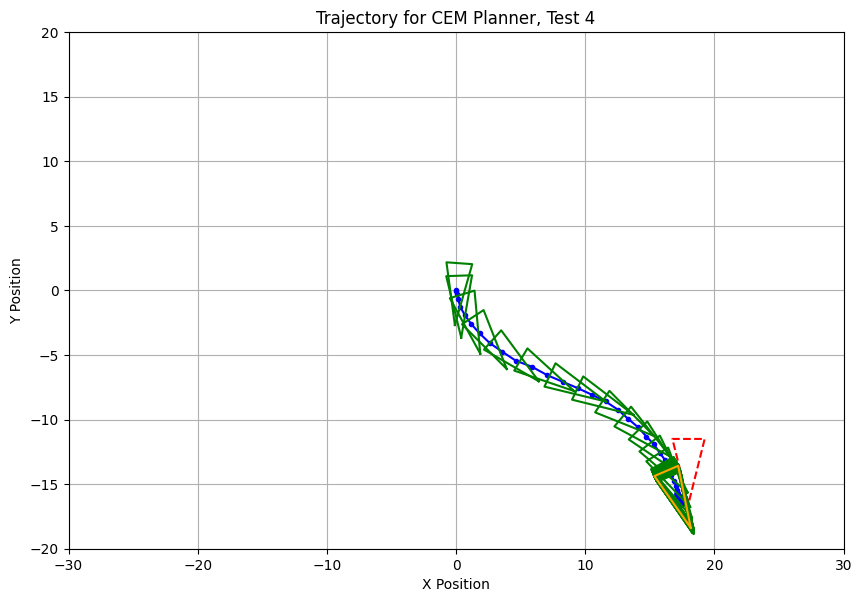

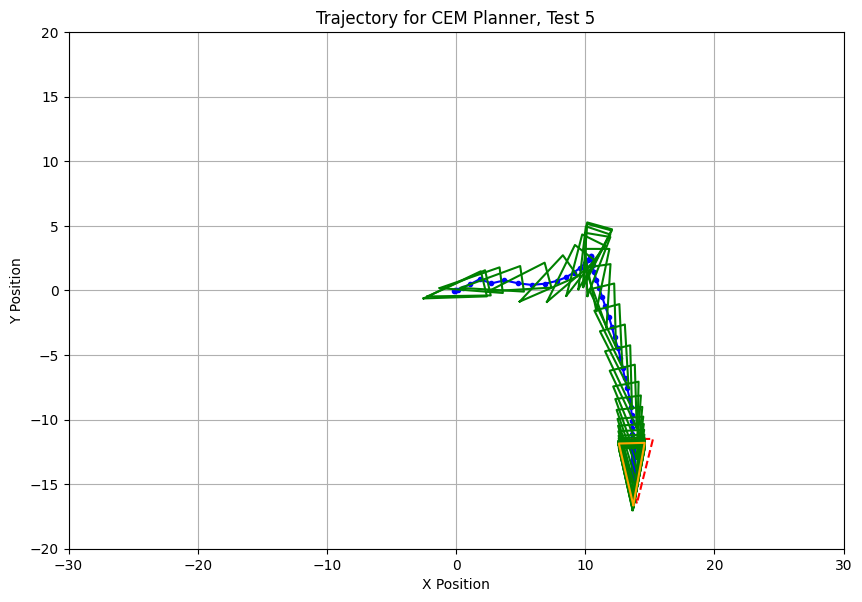

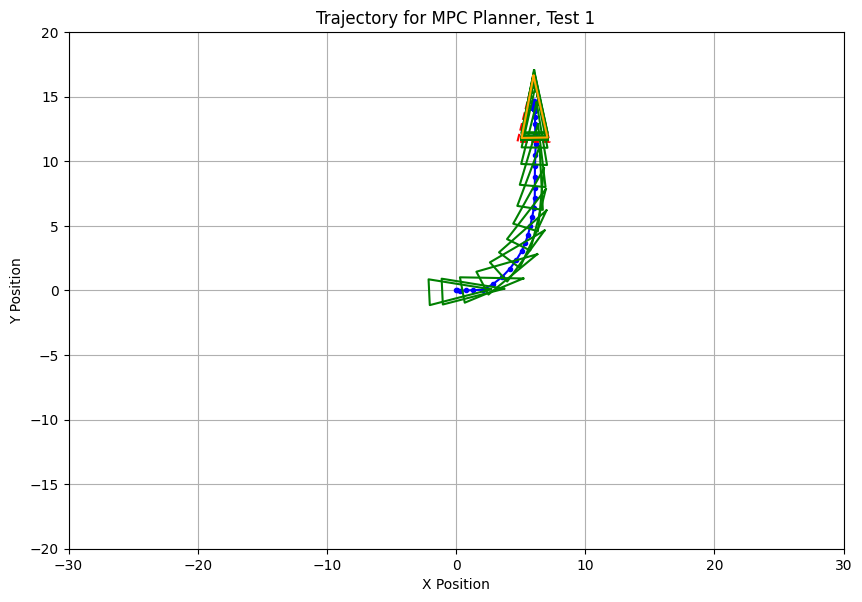

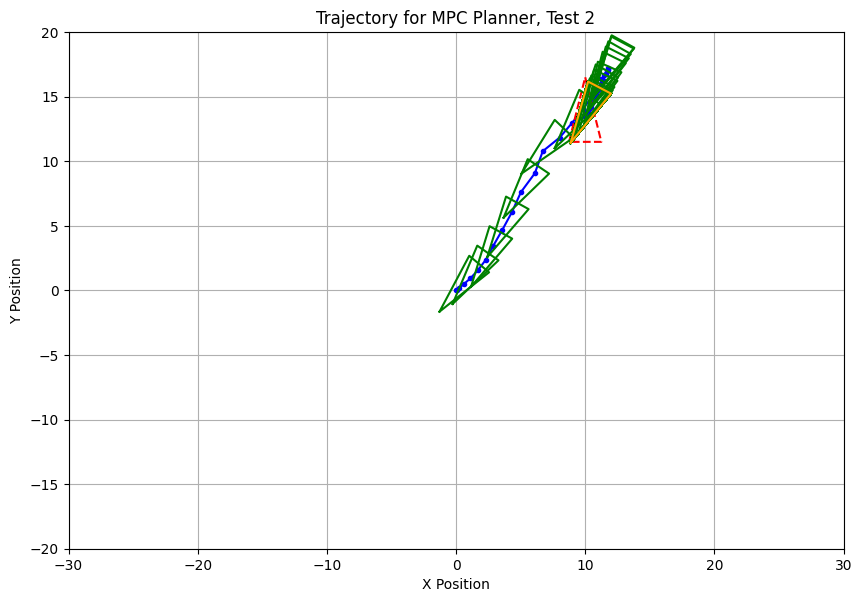

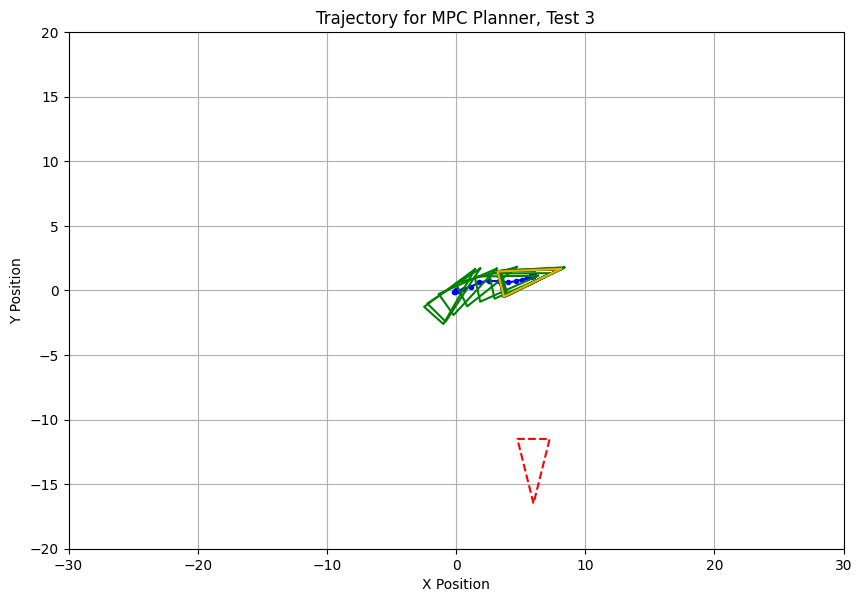

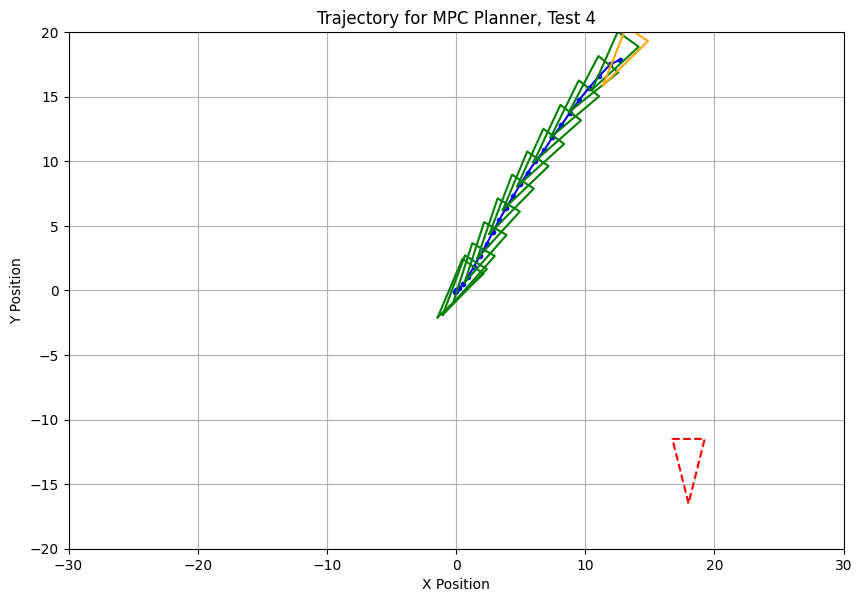

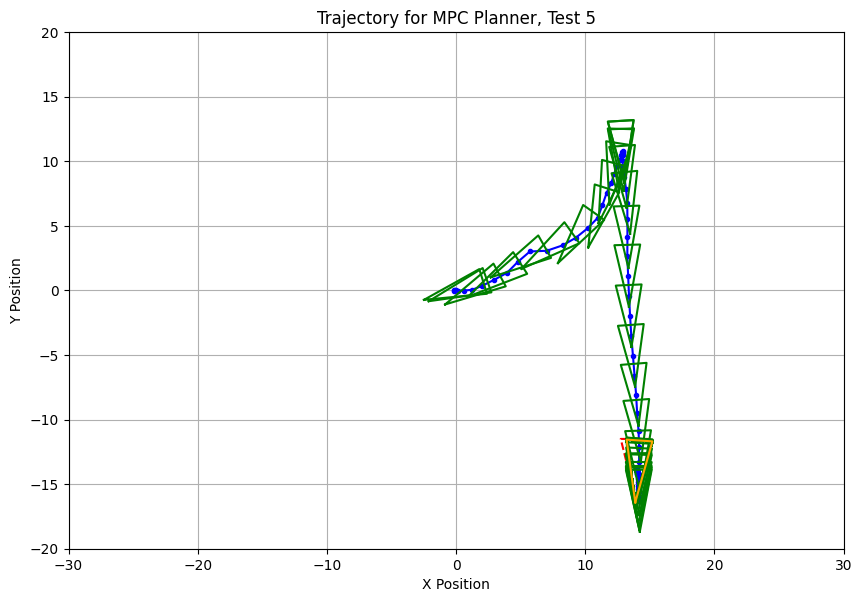

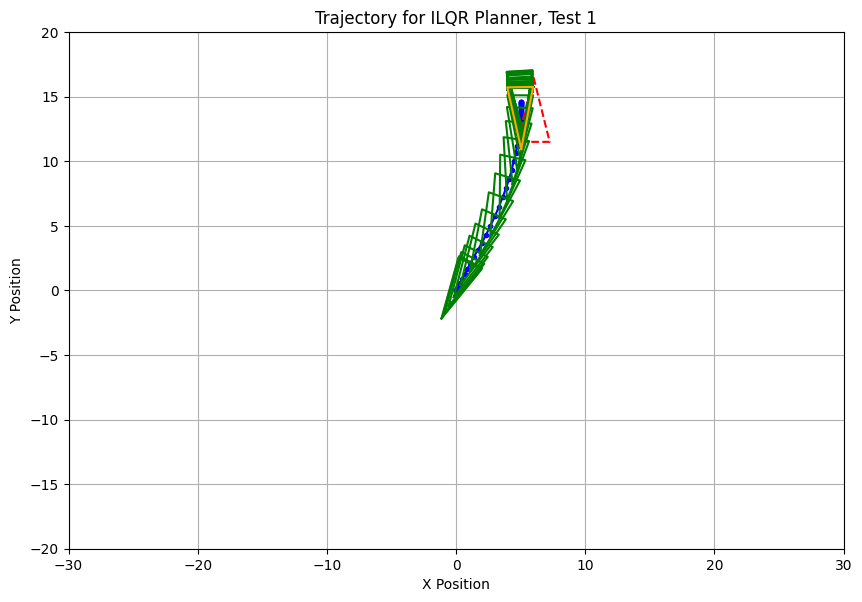

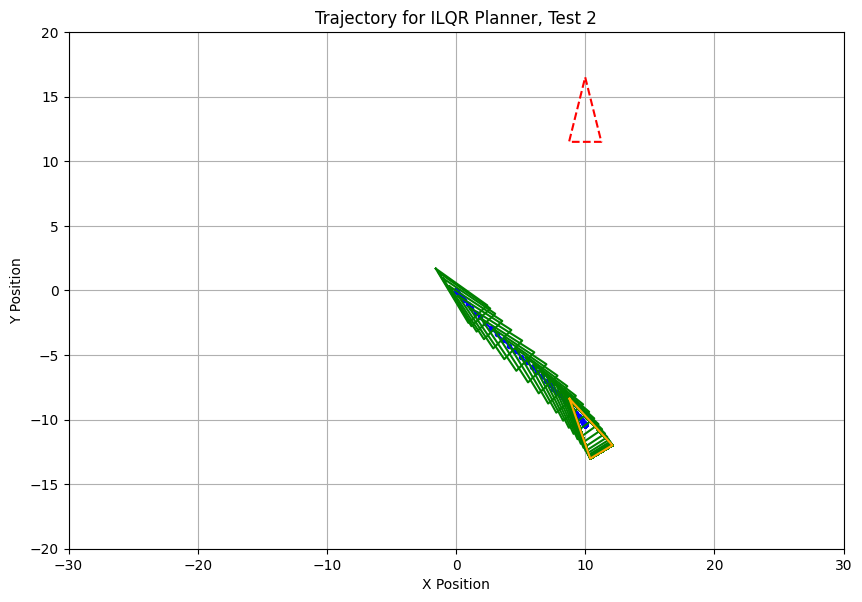

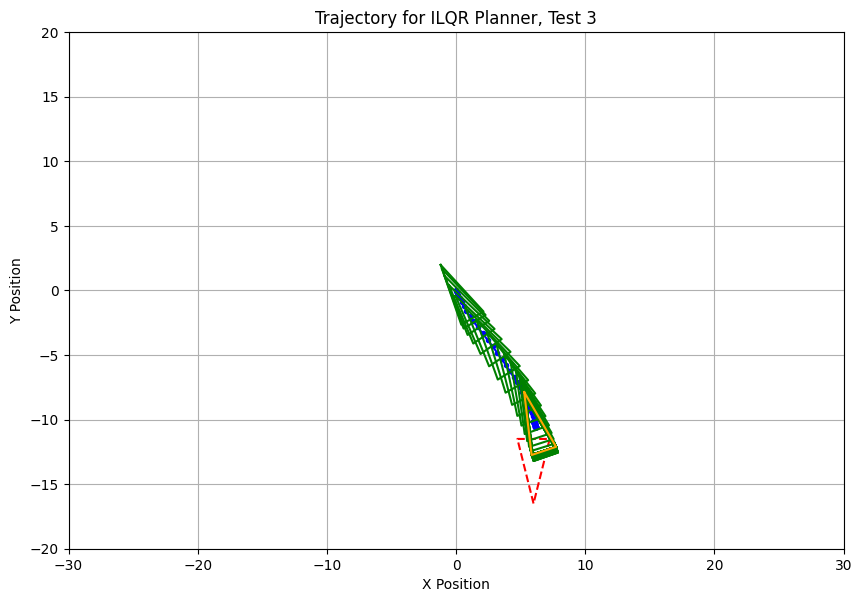

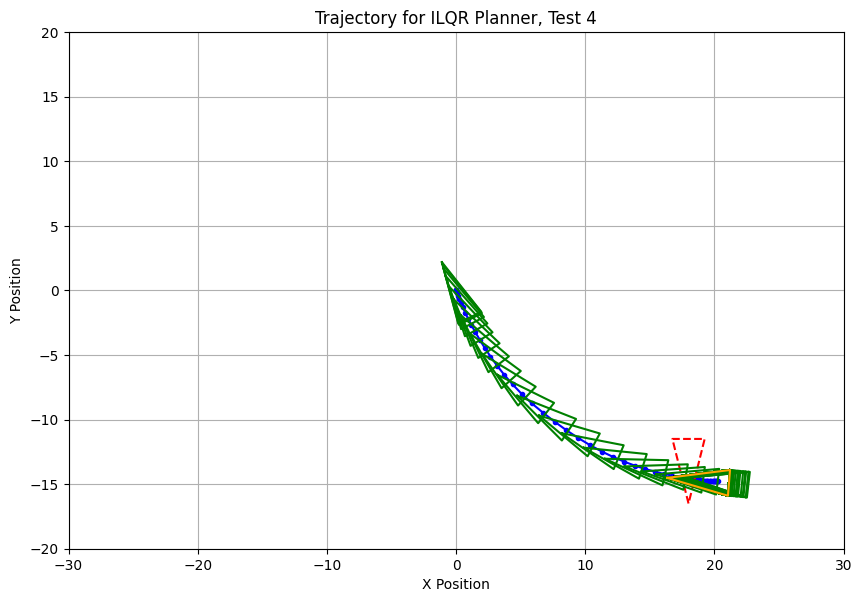

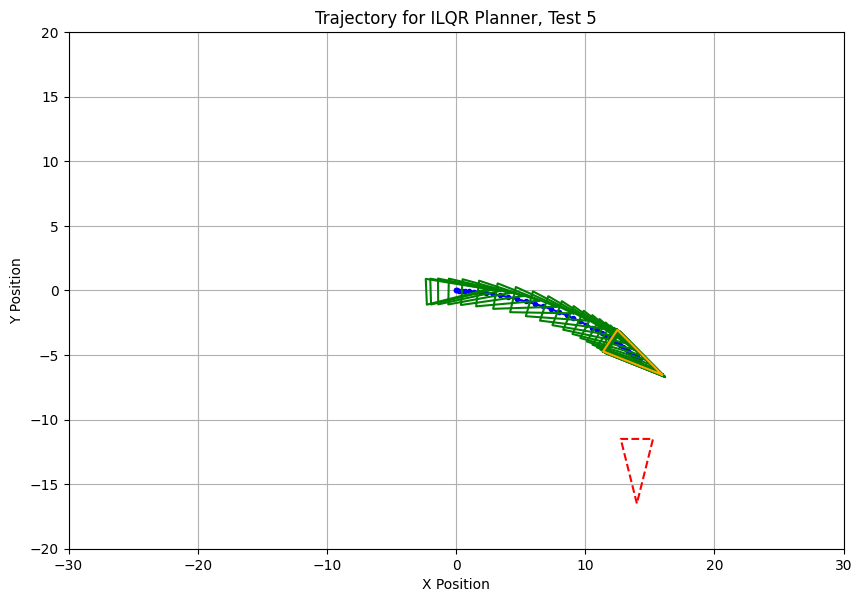

         Planner  Test Number  Total Reward  Elapsed Time  Crashed  Stuck  \
0    CEM Planner            1   -177.063177     36.986573    False   True   
1    CEM Planner            2   -211.727988     37.634941    False   True   
2    CEM Planner            3   -223.769947     38.916432    False   True   
3    CEM Planner            4   -227.591321     41.760286    False   True   
4    CEM Planner            5   -329.440163     38.500246    False   True   
5    MPC Planner            1   -265.756098     57.171796    False   True   
6    MPC Planner            2   -286.227259     59.510991    False   True   
7    MPC Planner            3   -312.274602     59.254575    False   True   
8    MPC Planner            4    -16.060619      3.596257     True  False   
9    MPC Planner            5   -266.204119     57.075147    False   True   
10  ILQR Planner            1   -241.107790    142.300125    False   True   
11  ILQR Planner            2   -317.035430    138.656691    False   True   

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from tqdm import trange

def set_env_state(env, observation, achieved_goal, desired_goal):
    env.reset()
    env.unwrapped.state = {
        'observation': observation.numpy(),
        'achieved_goal': achieved_goal.numpy(),
        'desired_goal': desired_goal.numpy()
    }

def plot_trajectory(trajectory, env, goal, planner_name, test_num, draw_interval=1):
    plt.figure(figsize=(10, 10))
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    trajectory = np.array(trajectory) * scales
    goal = goal * scales

    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', marker='.')

    # Drawing the parking spot as a triangle
    parking_spot_length = 5.0
    parking_spot_width = 2.5
    goal_x, goal_y = goal[0], goal[1]
    goal_sin, goal_cos = goal[5], goal[4]
    parking_spot_orientation = np.arctan2(goal_sin, goal_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
    triangle = np.array([
        [0, -parking_spot_length / 2],
        [-parking_spot_width / 2, parking_spot_length / 2],
        [parking_spot_width / 2, parking_spot_length / 2],
    ])
    rotation_matrix = np.array([
        [np.cos(parking_spot_orientation), -np.sin(parking_spot_orientation)],
        [np.sin(parking_spot_orientation), np.cos(parking_spot_orientation)]
    ])
    triangle = triangle @ rotation_matrix.T + np.array([goal_x, goal_y])
    plt.plot([triangle[0, 0], triangle[1, 0], triangle[2, 0], triangle[0, 0]],
             [triangle[0, 1], triangle[1, 1], triangle[2, 1], triangle[0, 1]], 'r--')

    for i, state in enumerate(trajectory):
        if (i!=0) and (i % draw_interval == 0 or i == len(trajectory) - 1):
            # Drawing the car as a triangle
            car_x, car_y = state[0], state[1]
            car_sin, car_cos = state[5], state[4]
            car_yaw = np.arctan2(car_sin, car_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
            car_length = 4.8
            car_width = 2.0
            car_triangle = np.array([
                [0, -car_length / 2],
                [-car_width / 2, car_length / 2],
                [car_width / 2, car_length / 2],
            ])
            rotation_matrix = np.array([
                [np.cos(car_yaw), -np.sin(car_yaw)],
                [np.sin(car_yaw), np.cos(car_yaw)]
            ])
            car_triangle = car_triangle @ rotation_matrix.T + np.array([car_x, car_y])
            color = 'g-' if i != len(trajectory) - 1 else 'orange'
            plt.plot([car_triangle[0, 0], car_triangle[1, 0], car_triangle[2, 0], car_triangle[0, 0]],
                     [car_triangle[0, 1], car_triangle[1, 1], car_triangle[2, 1], car_triangle[0, 1]], color)

    plt.title(f"Trajectory for {planner_name}, Test {test_num}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-30, 30)
    plt.ylim(-20, 20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

def test_planners(planners, env, num_tests=5, num_steps=100, draw_interval=1):
    results = []
    initial_conditions = []
    for test_num in range(num_tests):
        obs, info = env.reset()
        initial_state = torch.Tensor(obs["observation"])
        achieved_goal = torch.Tensor(obs["achieved_goal"])
        desired_goal = torch.Tensor(obs["desired_goal"])
        initial_conditions.append((initial_state, achieved_goal, desired_goal))
    env.unwrapped.config["duration"] = num_steps
    for planner_name, planner in planners.items():
        for test_num, (initial_state, achieved_goal, desired_goal) in enumerate(initial_conditions):
            set_env_state(env, initial_state, achieved_goal, desired_goal)
            start_time = time.time()
            total_reward = 0
            crashed = False
            stuck = False
            success = False
            trajectory = [initial_state.numpy()]
            done = False
            while not done:
                action = planner(initial_state, desired_goal, env.action_space.shape[0], env.observation_space.spaces["observation"].shape[0])
                # action = [0.001, 0.001]
                obs, reward, done, truncated, info = env.step(action.numpy())
                # obs, reward, done, truncated, info = env.step(action)
                total_reward += reward
                trajectory.append(torch.Tensor(obs["observation"]).numpy())
                if info.get('is_success', False):
                    success = True
                    break
                if info.get('crashed', False):
                    crashed = True
                    break
                if truncated:
                    stuck = True
                    break
                if done:
                    break

                initial_state = torch.Tensor(obs["observation"])
            end_time = time.time()
            elapsed_time = end_time - start_time
            results.append({
                "Planner": planner_name,
                "Test Number": test_num + 1,
                "Total Reward": total_reward,
                "Elapsed Time": elapsed_time,
                "Crashed": crashed,
                "Stuck": stuck,
                "Success": success
            })
            plot_trajectory(trajectory, env, desired_goal.numpy(), planner_name, test_num + 1, draw_interval)
    return results


planners = {
    "CEM Planner": lambda state, goal, action_size, state_size: cem_planner(state, goal, action_size),
    "MPC Planner": lambda state, goal, action_size, state_size: mpc_planner(dynamics, state, goal),
    "ILQR Planner": lambda state, goal, action_size, state_size: ilqr_planner(state, goal, dynamics, action_size, state_size)
}

env = gym.make("parking-v0", render_mode='rgb_array')
results = test_planners(planners, env, draw_interval=2)

# Вывод результатов в виде таблицы
df_results = pd.DataFrame(results)
print(df_results)

# Сохранение результатов в Excel файл
df_results.to_excel("test_results.xlsx", index=False)

Лучший тестировщик

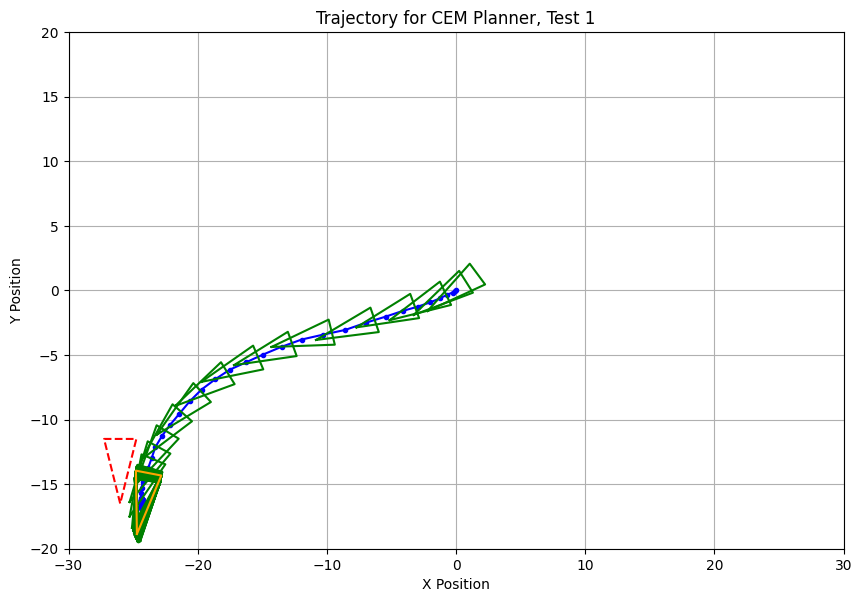

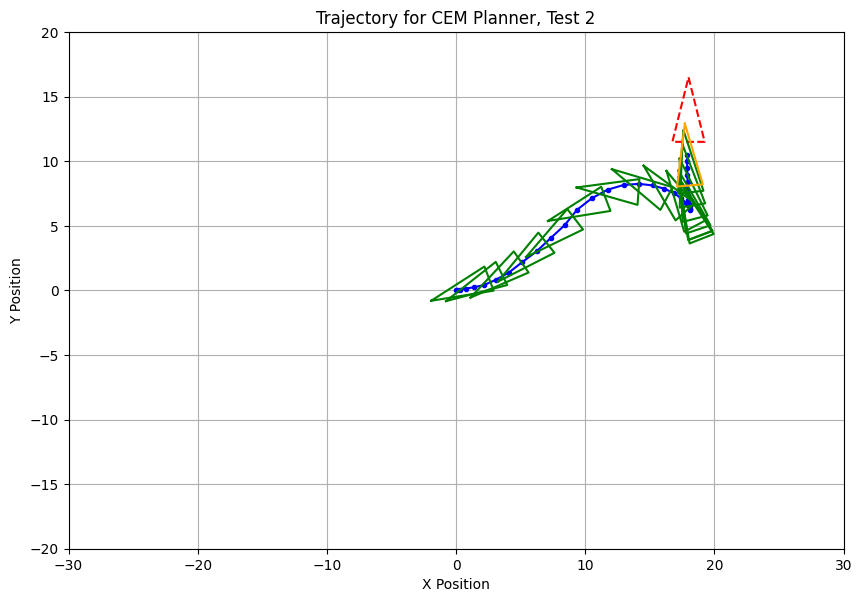

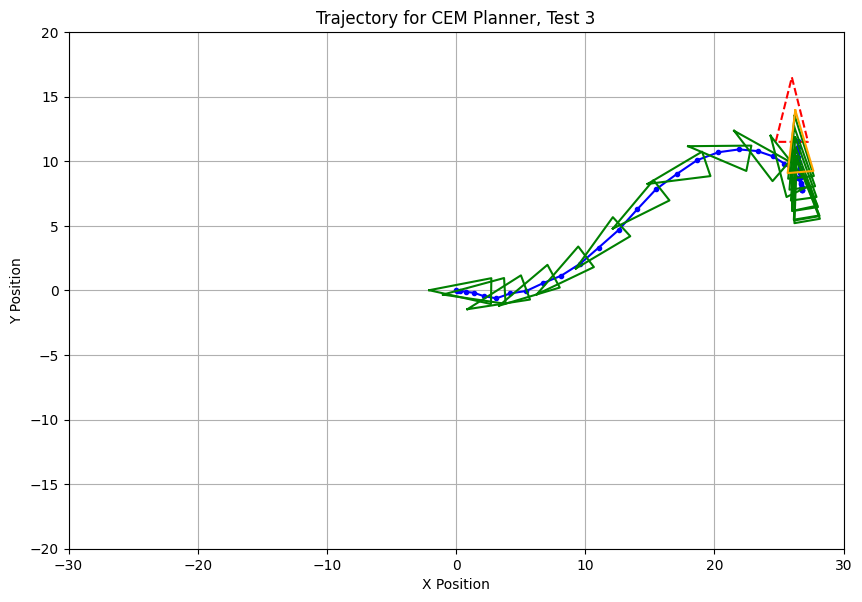

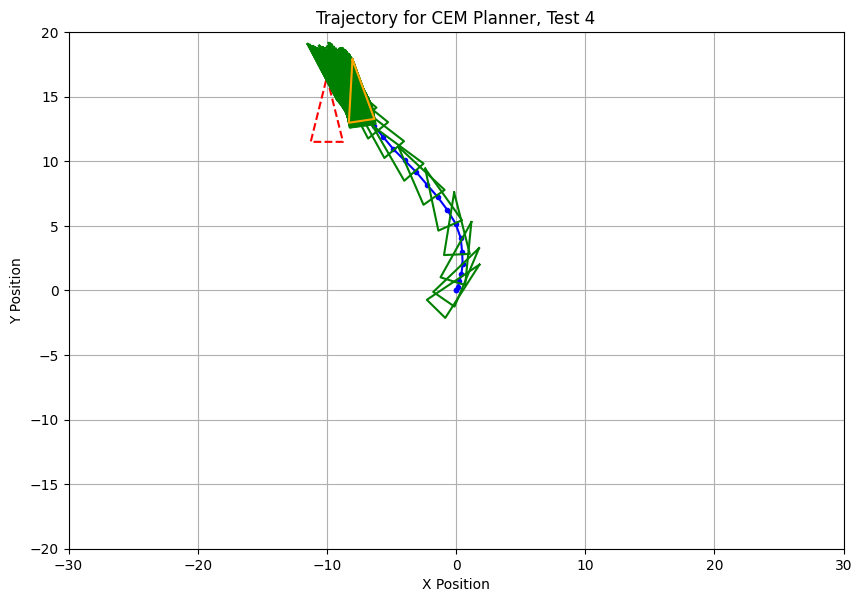

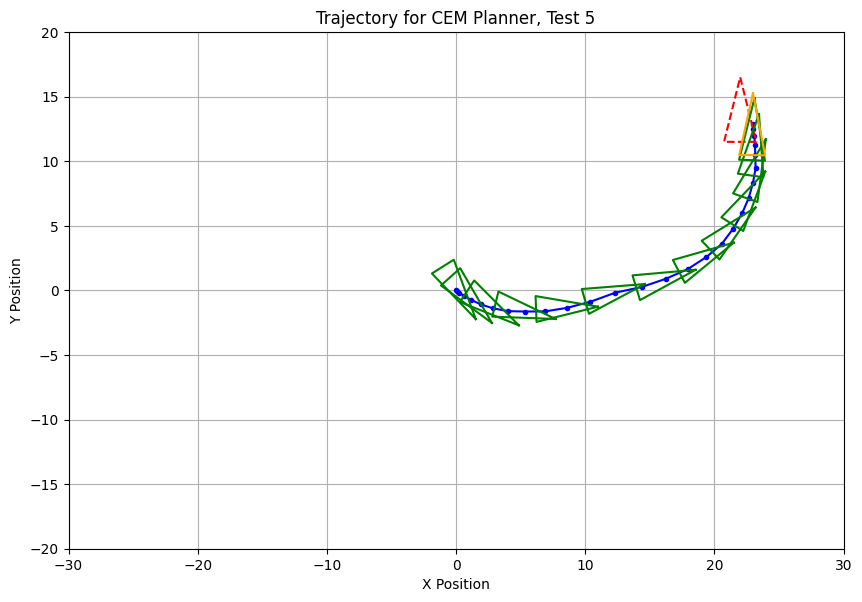

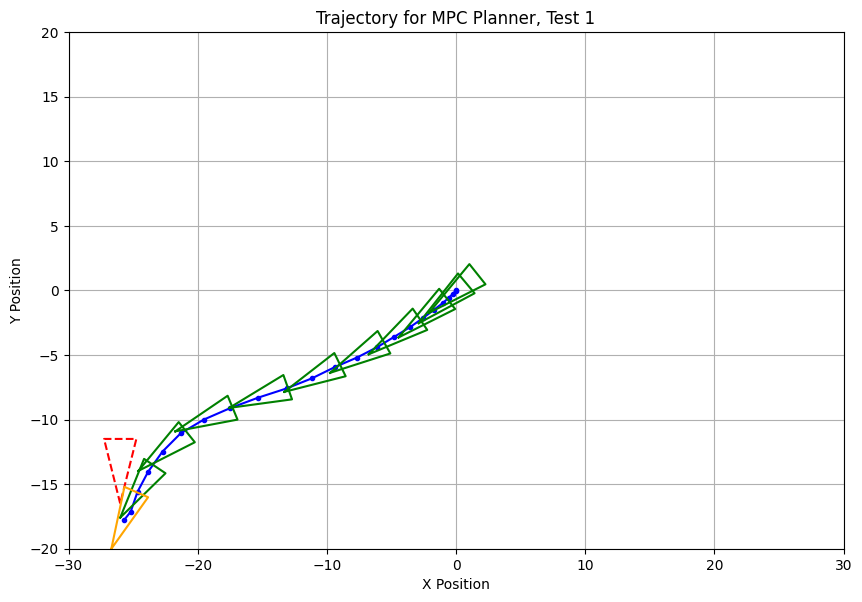

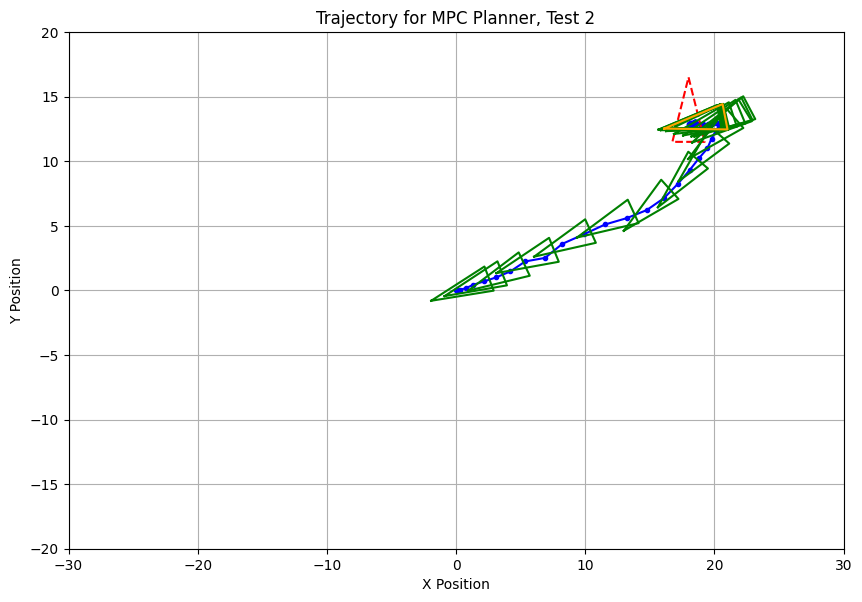

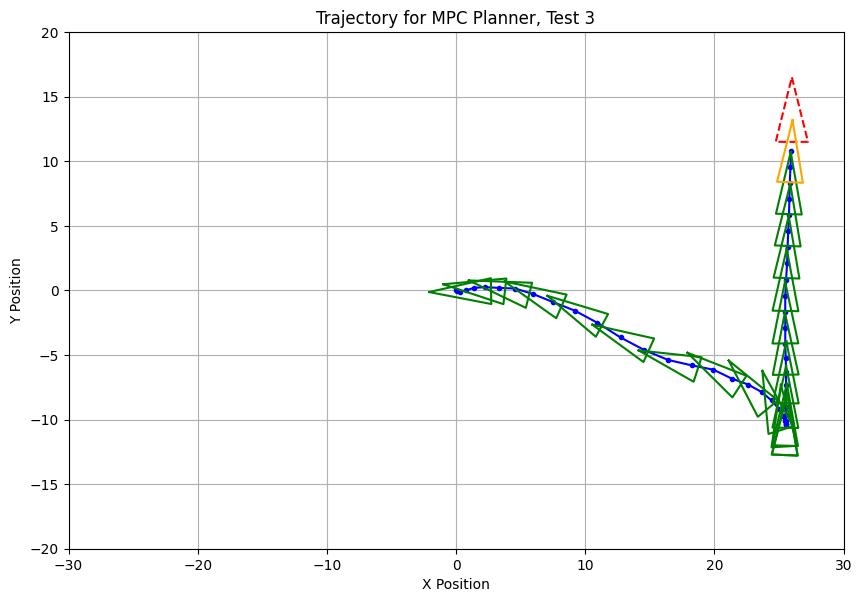

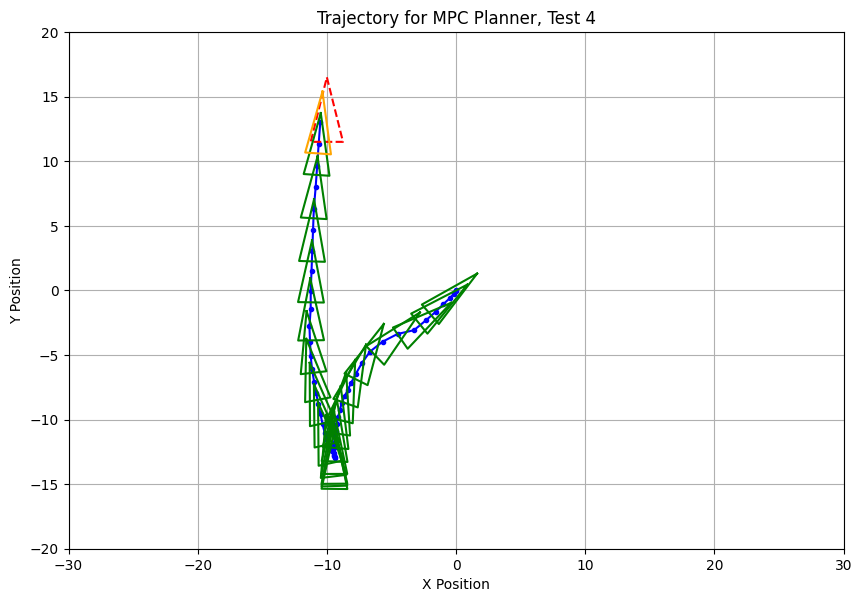

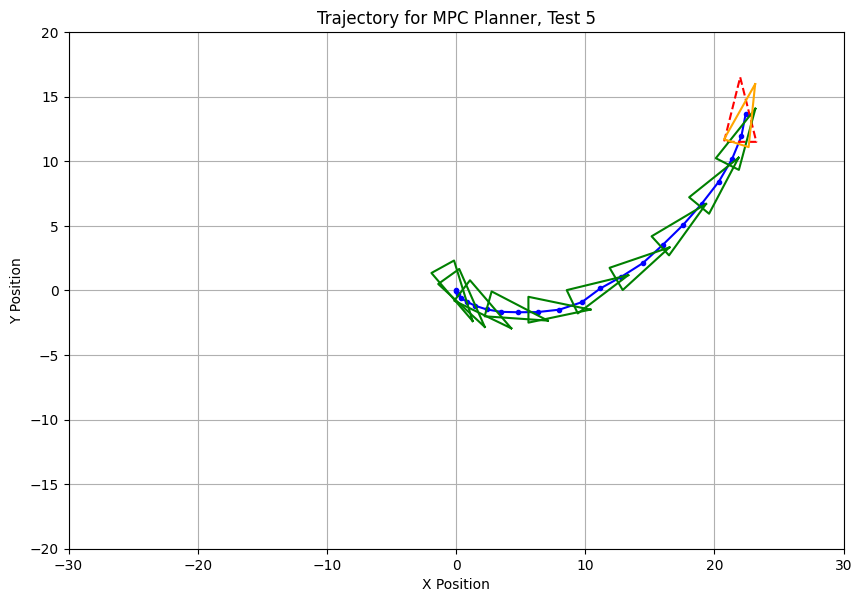

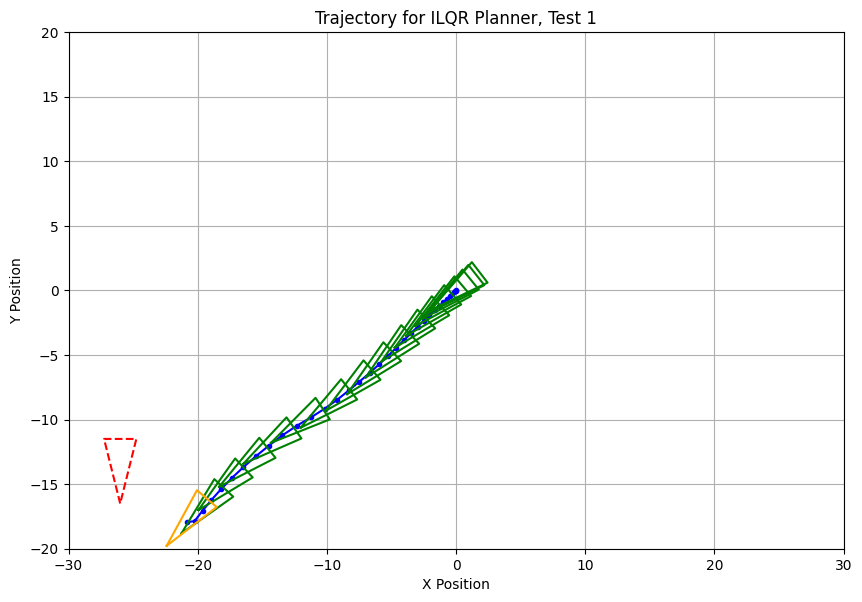

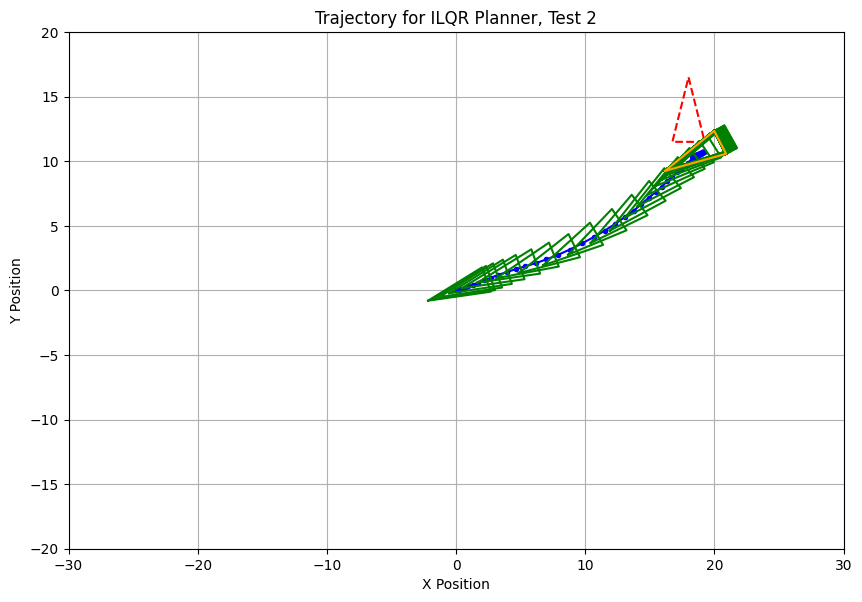

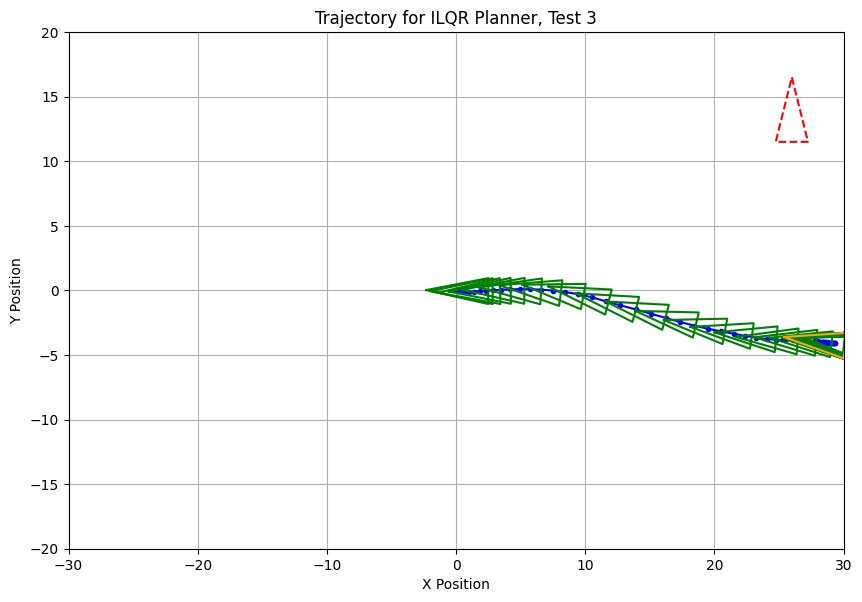

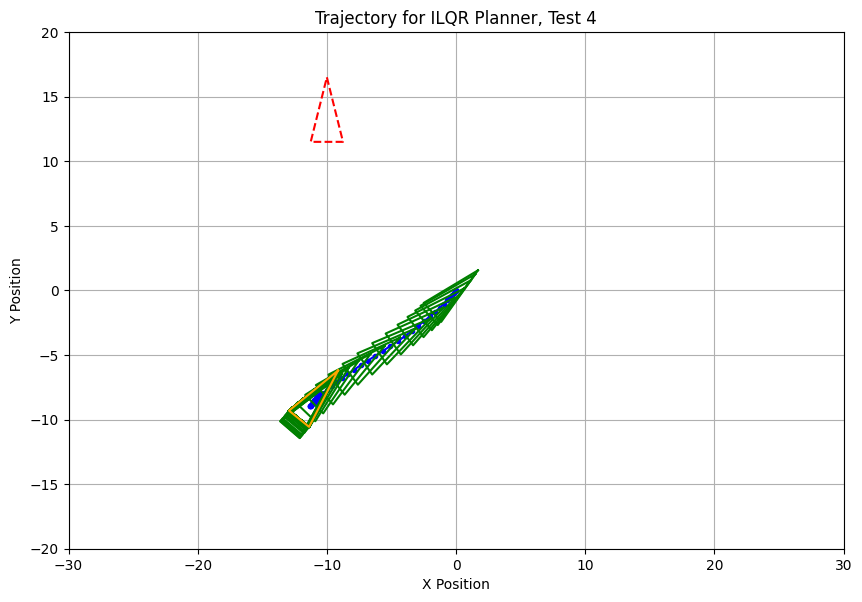

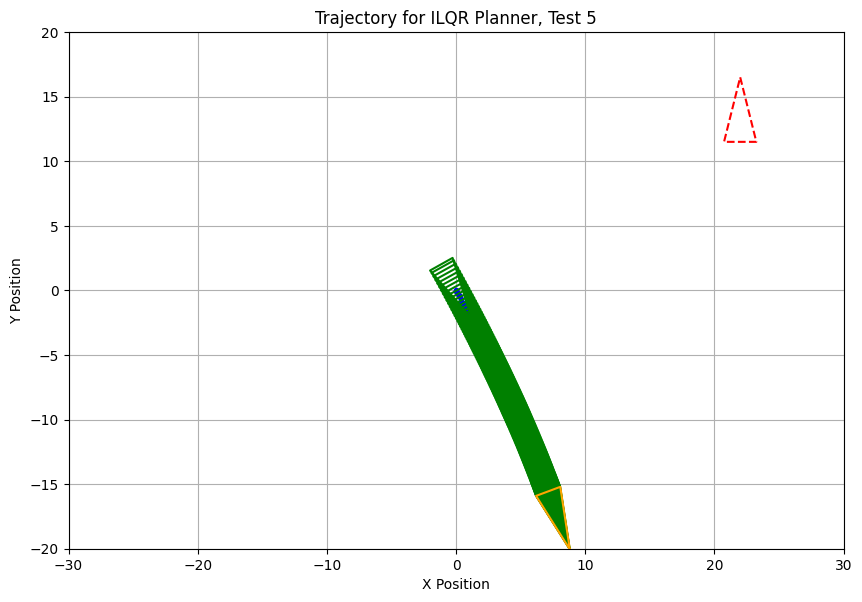

         Planner  Test Number  Total Reward  Elapsed Time  Not crashed  \
0    CEM Planner            1    -91.716277     44.007474         True   
1    CEM Planner            2    -10.282907      2.697005         True   
2    CEM Planner            3    -12.463033      3.965220         True   
3    CEM Planner            4    -90.972964     41.417851         True   
4    CEM Planner            5     -9.489073      1.984814         True   
5    MPC Planner            1    -14.055060      2.646249        False   
6    MPC Planner            2   -116.609515     64.325242         True   
7    MPC Planner            3    -15.371411      7.903229         True   
8    MPC Planner            4    -14.500598      5.820389         True   
9    MPC Planner            5     -8.521005      2.409746         True   
10  ILQR Planner            1    -20.758257     11.307288        False   
11  ILQR Planner            2   -129.122882    164.268734         True   
12  ILQR Planner            3   -170.1

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from tqdm import trange
import gymnasium as gym

def plot_trajectory(trajectory, env, goal, planner_name, test_num, draw_interval=1):
    plt.figure(figsize=(10, 10))
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    trajectory = np.array(trajectory) * scales
    goal = goal * scales

    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', marker='.')

    # Drawing the parking spot as a triangle
    parking_spot_length = 5.0
    parking_spot_width = 2.5
    goal_x, goal_y = goal[0], goal[1]
    goal_sin, goal_cos = goal[5], goal[4]
    parking_spot_orientation = np.arctan2(goal_sin, goal_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
    triangle = np.array([
        [0, -parking_spot_length / 2],
        [-parking_spot_width / 2, parking_spot_length / 2],
        [parking_spot_width / 2, parking_spot_length / 2],
    ])
    rotation_matrix = np.array([
        [np.cos(parking_spot_orientation), -np.sin(parking_spot_orientation)],
        [np.sin(parking_spot_orientation), np.cos(parking_spot_orientation)]
    ])
    triangle = triangle @ rotation_matrix.T + np.array([goal_x, goal_y])
    plt.plot([triangle[0, 0], triangle[1, 0], triangle[2, 0], triangle[0, 0]],
             [triangle[0, 1], triangle[1, 1], triangle[2, 1], triangle[0, 1]], 'r--')

    for i, state in enumerate(trajectory):
        if (i != 0) and (i % draw_interval == 0 or i == len(trajectory) - 1):
            # Drawing the car as a triangle
            car_x, car_y = state[0], state[1]
            car_sin, car_cos = state[5], state[4]
            car_yaw = np.arctan2(car_sin, car_cos) + np.pi / 2  # Rotate by 90 degrees clockwise
            car_length = 4.8
            car_width = 2.0
            car_triangle = np.array([
                [0, -car_length / 2],
                [-car_width / 2, car_length / 2],
                [car_width / 2, car_length / 2],
            ])
            rotation_matrix = np.array([
                [np.cos(car_yaw), -np.sin(car_yaw)],
                [np.sin(car_yaw), np.cos(car_yaw)]
            ])
            car_triangle = car_triangle @ rotation_matrix.T + np.array([car_x, car_y])
            color = 'g-' if i != len(trajectory) - 1 else 'orange'
            plt.plot([car_triangle[0, 0], car_triangle[1, 0], car_triangle[2, 0], car_triangle[0, 0]],
                     [car_triangle[0, 1], car_triangle[1, 1], car_triangle[2, 1], car_triangle[0, 1]], color)

    plt.title(f"Trajectory for {planner_name}, Test {test_num}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(-30, 30)
    plt.ylim(-20, 20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

def test_planners(planners, env_name, num_tests=5, draw_interval=1):
    results = []
    seeds = np.random.randint(0, 10000, size=num_tests)
    for planner_name, planner in planners.items():
        for test_num in range(num_tests):
            env = gym.make(env_name)
            env.action_space.seed(int(seeds[test_num]))
            obs, info = env.reset(seed=int(seeds[test_num]))
            initial_state = torch.Tensor(obs["observation"])
            achieved_goal = torch.Tensor(obs["achieved_goal"])
            desired_goal = torch.Tensor(obs["desired_goal"])
            start_time = time.time()
            total_reward = 0
            crashed = False
            stuck = False
            success = False
            trajectory = [initial_state.numpy()]
            done = False
            while not done:
                action = planner(initial_state, desired_goal, env.action_space.shape[0], env.observation_space.spaces["observation"].shape[0])
                obs, reward, done, truncated, info = env.step(action.numpy())
                total_reward += reward
                trajectory.append(torch.Tensor(obs["observation"]).numpy())
                if info.get('is_success', False):
                    success = True
                    done = True
                if info.get('crashed', False):
                    crashed = True
                    done = True
                if truncated:
                    stuck = True
                    done = True
                if done:
                    break

                initial_state = torch.Tensor(obs["observation"])
            end_time = time.time()
            elapsed_time = end_time - start_time
            results.append({
                "Planner": planner_name,
                "Test Number": test_num + 1,
                "Total Reward": total_reward,
                "Elapsed Time": elapsed_time,
                "Not crashed": not crashed,
                "Not stuck": not stuck,
                "Success": success
            })
            plot_trajectory(trajectory, env, desired_goal.numpy(), planner_name, test_num + 1, draw_interval)
    return results

planners = {
    "CEM Planner": lambda state, goal, action_size, state_size: cem_planner(state, goal, action_size),
    "MPC Planner": lambda state, goal, action_size, state_size: mpc_planner(dynamics, state, goal),
    "ILQR Planner": lambda state, goal, action_size, state_size: ilqr_planner(state, goal, dynamics, action_size, state_size)
}

env_name = "parking-v0"
results = test_planners(planners, env_name, draw_interval=2)

# Вывод результатов в виде таблицы
df_results = pd.DataFrame(results)
print(df_results)

# Сохранение результатов в Excel файл
df_results.to_excel("test_results.xlsx", index=False)

In [ ]:
import gymnasium as gym
import highway_env
import torch

# Создание окружения
env = gym.make("parking-v0", render_mode="rgb_array")
obs, info = env.reset()

# Начальное состояние
initial_state = torch.Tensor(obs["observation"])
achieved_goal = torch.Tensor(obs["achieved_goal"])
desired_goal = torch.Tensor(obs["desired_goal"])

# Задаем действия для движения вперед (газ на максимум, угол рулевого колеса - 0)
action = [.001, 0.001]  # Максимальное ускорение и нулевой угол рулевого колеса

# Максимальное количество шагов
max_steps = 100
env.unwrapped.config["duration"] = 98
# Запуск цикла для проверки информации при каждом шаге
for step in range(max_steps):
    obs, reward, done, truncated, info = env.step(action)
    print(f"Step: {step + 1}")
    print(f"Info: {info}", end = " ")
    print(f"truncted: {truncated}", end = " ")
    print(f"Done: {done}")

    if done or truncated:
        print("Episode ended.")
        break

env.close()



Step: 1
Info: {'speed': 0.000999999999999801, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 2
Info: {'speed': 0.0019999999999996024, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 3
Info: {'speed': 0.0029999999999994038, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 4
Info: {'speed': 0.003999999999999205, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 5
Info: {'speed': 0.004999999999999006, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 6
Info: {'speed': 0.0059999999999988075, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 7
Info: {'speed': 0.006999999999998609, 'crashed': False, 'action': [0.001, 0.001], 'is_success': False} truncted: False Done: False
Step: 8
Info: {'speed': 

## Visualize a few episodes

En voiture, Simone !

In [ ]:
env = gym.make("parking-v0", render_mode='rgb_array')
env = record_videos(env)
obs, info = env.reset()

for step in trange(3 * env.config["duration"], desc="Testing 3 episodes..."):
    action = cem_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0])
    obs, reward, done, truncated, info = env.step(action.numpy())
    if done or truncated:
        print(f"Info: {info}", end = " ")
        print(f"truncted: {truncated}", end = " ")
        print(f"Done: {done}")
        obs, info = env.reset()
env.close()
show_videos()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(
Testing 3 episodes...:  10%|▉         | 29/300 [00:03<00:33,  8.05it/s]

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4




Testing 3 episodes...:  10%|█         | 31/300 [00:04<01:29,  2.99it/s]

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Info: {'speed': 2.3928345888853024, 'crashed': False, 'action': array([-0.32081372,  0.31106633], dtype=float32), 'is_success': True} truncted: False Done: True


Testing 3 episodes...:  19%|█▉        | 57/300 [00:08<00:30,  7.90it/s]

Moviepy - Building video /content/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-1.mp4




Testing 3 episodes...:  19%|█▉        | 58/300 [00:09<02:16,  1.77it/s]

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-1.mp4
Info: {'speed': 1.7175011783838328, 'crashed': False, 'action': array([-0.12646838,  0.438872  ], dtype=float32), 'is_success': True} truncted: False Done: True


Testing 3 episodes...:  28%|██▊       | 85/300 [00:14<00:27,  7.79it/s]

Moviepy - Building video /content/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-2.mp4




Testing 3 episodes...:  29%|██▉       | 87/300 [00:15<01:06,  3.19it/s]

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-2.mp4
Info: {'speed': 1.324407718578976, 'crashed': True, 'action': array([-0.26276833,  0.8530116 ], dtype=float32), 'is_success': False} truncted: False Done: True


Testing 3 episodes...:  42%|████▏     | 127/300 [00:20<00:21,  8.18it/s]

Moviepy - Building video /content/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-3.mp4




Testing 3 episodes...:  43%|████▎     | 129/300 [00:21<01:06,  2.57it/s]

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-3.mp4
Info: {'speed': -0.6642930409871038, 'crashed': False, 'action': array([-0.13037467,  0.83270377], dtype=float32), 'is_success': True} truncted: False Done: True


Testing 3 episodes...:  53%|█████▎    | 159/300 [00:26<00:17,  8.17it/s]

Moviepy - Building video /content/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-4.mp4




Testing 3 episodes...:  54%|█████▎    | 161/300 [00:27<00:49,  2.83it/s]

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-4.mp4
Info: {'speed': 2.50373998354189, 'crashed': False, 'action': array([-0.079972  ,  0.31395668], dtype=float32), 'is_success': True} truncted: False Done: True


Testing 3 episodes...: 100%|██████████| 300/300 [00:46<00:00,  6.44it/s]


Moviepy - Building video /content/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-5.mp4


In [ ]:
# Let's try it!
# Make the environment, and run an episode with random actions:
env = gym.make("parking-v0", render_mode="rgb_array")
env = record_videos(env)
obs, info = env.reset()

k=0
done = False
while not done:
    action = mpc_planner(dynamics, torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]))
    k=k+1
    obs, reward, done, truncated, info = env.step(action)
    if k==100:
      done=True
env.close()
show_videos()

In [ ]:
# Let's try it!
# Make the environment, and run an episode with random actions:
env = gym.make("parking-v0", render_mode="rgb_array")
env = record_videos(env)
obs, info = env.reset()

k=0
done = False
while not done:
    action = ilqr_planner(torch.Tensor(obs["observation"]), torch.Tensor(obs["desired_goal"]), dynamics, env.action_space.shape[0], env.observation_space.spaces["observation"].shape[0])
    k=k+1
    obs, reward, done, truncated, info = env.step(action)
    if k==100:
      done=True
env.close()
show_videos()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


## Limitations

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a **bias** that can only **decrease the true performance** of the corresponding planned policy. This is called the problem of model bias.

In some MDPs, even slight model errors lead to a dramatic drop in performance, as illustrated in the beginning of the following video:

[![Approximate Robust Control of Uncertain Dynamical Systems](https://img.youtube.com/vi/8khqd3BJo0A/0.jpg)](https://www.youtube.com/watch?v=8khqd3BJo0A)

The question of how to address model bias belongs to the field of **Safe Reinforcement Learning**.

### [The call of the void](https://www.urbandictionary.com/define.php?term=the%20call%20of%20the%20void)

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and **hallucinate** important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to **exploit** these hallucinated high rewards and will steer the agent towards **unknown** (and thus dangerous) **regions** where the model is erroneously optimistic.

### Computational cost of planning

At test time, the planning step typically requires **sampling a lot of trajectories** to find a near-optimal candidate, wich may turn out to be very costly. This may be prohibitive in a high-frequency real-time setting. The **model-free** methods which directly recommend the best action are **much more efficient** in that regard.